In [ ]:
"""Описание проекта

Проект посвящен регрессионному анализу связи параметров оказания медицинской помощи на уровне субъекта РФ 
с одногодичной летальностью, грубой и стандартизованной смертностью от онкологических заболеваний.

Цель - построить регрессионные модели, которые позволяли бы прогнозировать каждый из перечисленных целевых показателей 
(одногодичная летальность, грубая и стандартизованная смертность).

Число наблюдений - 85 по числу субъектов РФ.
Анализ проведен для 2017, 2018, 2019 и 2020 годов. Далее приведены результаты за 2017 год.

Список потенциальных предикторов в 2017 году:
1) Доля закупок таргетных лекарственных препаратов (ЛП), %
2) Доля выявленных злокачественных новообразований (ЗНО) на 1 стадии, %
3) Доля выявленных ЗНО на 2 стадии, %
4) Доля выявленных ЗНО на 3 стадии, %
5) Доля выявленных ЗНО на 4 стадии, %
6) Доля первично-множественных опухолей от впервые выявленных пациентов, %
7) Радикальное лечение впервые выявленных ЗНО, законченных в отчетном году, %
8) Радикальное лечение впервые выявленных ЗНО будет продолжено в отчетном периоде, %
9) Доля впервые выявленных ЗНО, лечение которых проведено только хирургически, от всех пролеченных, %
10) Доля впервые выявленных ЗНО, лечение которых проведено только лучевыми методами, от всех пролеченных, %
11) Доля впервые выявленных ЗНО, лечение которых проведено только лекарственными методами, от всех пролеченных, %
12) Доля впервые выявленных ЗНО, лечение которых проведено комбинированными методами (кроме химиолучевого), от всех пролеченных, %
13) Доля впервые выявленных ЗНО, лечение которых проведено химиолучевым методом, от всех пролеченных, %
14) Обеспеченность онкологами на 10000 соотв. населения
15) Обеспеченность онкологическими койками на 10000 соотв. населения

Источники данных: официальные статистические наблюдения, данные по таргетным ЛП - собственный анализ закупок.
Автор: Горкавенко Филипп Васильевич
"""

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats
from scipy.stats import kstest

import statsmodels.api as sm
from pylab import rcParams

# чтобы можно было просматривать все столбцы датафрейма
pd.options.display.max_columns = 100
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 12})

In [3]:
# Подготовка датасетов

# Для 2017 года

DATASET_PATH_2017 = 'C:/Onco_predict/dataset_stats_2017.csv'
dataset_2017_df = pd.read_csv(DATASET_PATH_2017, sep=';')
dataset_2017_df.index = dataset_2017_df['Subyekt']

In [6]:
# Функция для построения диаграмм для определения нормальности.

def my_hist_norm_distr_test(variable, n_bins, variable_name):
    
    variable.hist(bins=n_bins)

    plt.ylabel('Число наблюдений')
    plt.xlabel("Значения целевого показателя")
    plt.title(variable_name)
    
    plt.show()

    sns.distplot(variable, bins=n_bins)
    
    print(shapiro(variable))
    print(normaltest(variable))
    print(kstest(variable, 'norm'))
    
def my_norm_distr_test(variable):
    
    print(shapiro(variable))
    print(normaltest(variable))
    print(kstest(variable, 'norm'))

In [7]:
# Функция для построения корреляционной матрицы
# По умолчанию уровень значимости = 0.2

def my_corr_matrix(dataset, signif_value):
    
    plt.figure(figsize=(15,10))
    sns.set(font_scale=1)
    x = dataset.corr().round(2)
    x[np.abs(x) < signif_value] = 0

    sns.heatmap(x, annot=True, linewidths=.5, cmap='coolwarm')

    plt.title('Correlation matrix')
    plt.show()

In [5]:
# Функция для быстрой постройки регрессионной модели модели. Использована также в составе функции my_project_analysis

def my_regression_simple(features, target):
    
    x = sm.add_constant(features)
    est = sm.OLS(target, x)
    est2 = est.fit()
    print(est2.summary())

In [9]:
# Основная функция для регрессионного анализа в данном проекте. Предварительный этап перед построением итоговых моделей
# с использованием функции my_regression_simple

def my_project_analysis(features, target):
    #Выводит список коэффициентов корреляции каждой фичи с целевой переменной
    for column in features.columns:                 
        print(column, features[column].corr(target))
    #Визуализация распределения фичи и целевого показателя с регрессионными кривыми 
    for column in features.columns:
        plt.figure()
        sns.regplot(features[column], target)
    #Выводит список простых линейных моделей каждой фичи с целевым показателем 
    for column in features.columns:
        result = my_regression_simple(features[column], target)

# 2017 год

## Одногодичная летальность

In [10]:
#Подготовка датасетов

#Представленные далее датасеты уже итоговые результаты. Сначала на основе визуального анализа гистограмм распределения 
#всех преликторов и целевых показателей выделялись субъекты с выбросами - они исключались из анализа 
#(Ленинградская область и респ. Кабардино-Балкария). Затем после дополнительного анализа выбросов были исключены
#'Chukotskiyavt.okrug', 'Moskovskayaoblast', 'RespublikaAltay', 'Rostovskayaoblast', 'Nenetskiya.o.', 'RespublikaChechnya.

dataset_2017_df_opt = dataset_2017_df.drop(labels = ['Leningradskayaoblast', 'Resp.Kabardino-Balkariya'],axis = 0)
#Оптимизация под 1th_year_mort_2017
dataset_2017_for_1th_year_mort_2017_df_opt = dataset_2017_df_opt.drop(labels = ['Chukotskiyavt.okrug', 'Moskovskayaoblast', 'RespublikaAltay', 'Rostovskayaoblast', 'Nenetskiya.o.', 'RespublikaChechnya'],axis = 0)
#Датасет с предикторами (фичами)
dataset_2017_features_for_1th_year_mort_2017_df = dataset_2017_for_1th_year_mort_2017_df_opt.drop(['Subyekt', '1th_year_mort_2017', 'death_simple_2017', 'death_stnd_2017', '5y_surv_2017'], axis=1)

#for 1-year mort 'Moskovskayaoblast', 'RespublikaAltay', 'Rostovskayaoblast',
dataset_2017_1th_year_mort_2017_df = dataset_2017_for_1th_year_mort_2017_df_opt[['1th_year_mort_2017']]



array([[<AxesSubplot:title={'center':'targ_share_2017'}>,
        <AxesSubplot:title={'center':'pmzno_2017'}>,
        <AxesSubplot:title={'center':'first_stage_2017'}>,
        <AxesSubplot:title={'center':'second_stage_2017'}>],
       [<AxesSubplot:title={'center':'third_stage_2017'}>,
        <AxesSubplot:title={'center':'fourth_stage_2017'}>,
        <AxesSubplot:title={'center':'treatm_over_2017'}>,
        <AxesSubplot:title={'center':'treatm_non-over_2017'}>],
       [<AxesSubplot:title={'center':'treatm_1st_surgery_2017'}>,
        <AxesSubplot:title={'center':'treatm_1st_radiation_2017'}>,
        <AxesSubplot:title={'center':'treatm_1st_drug_2017'}>,
        <AxesSubplot:title={'center':'treatm_1st_comb_2017'}>],
       [<AxesSubplot:title={'center':'treatm_1st_drug-rad_2017'}>,
        <AxesSubplot:title={'center':'onco_doct_per_100000_pop_2017'}>,
        <AxesSubplot:title={'center':'onco_bed_per_100000_pop_2017'}>,
        <AxesSubplot:>]], dtype=object)

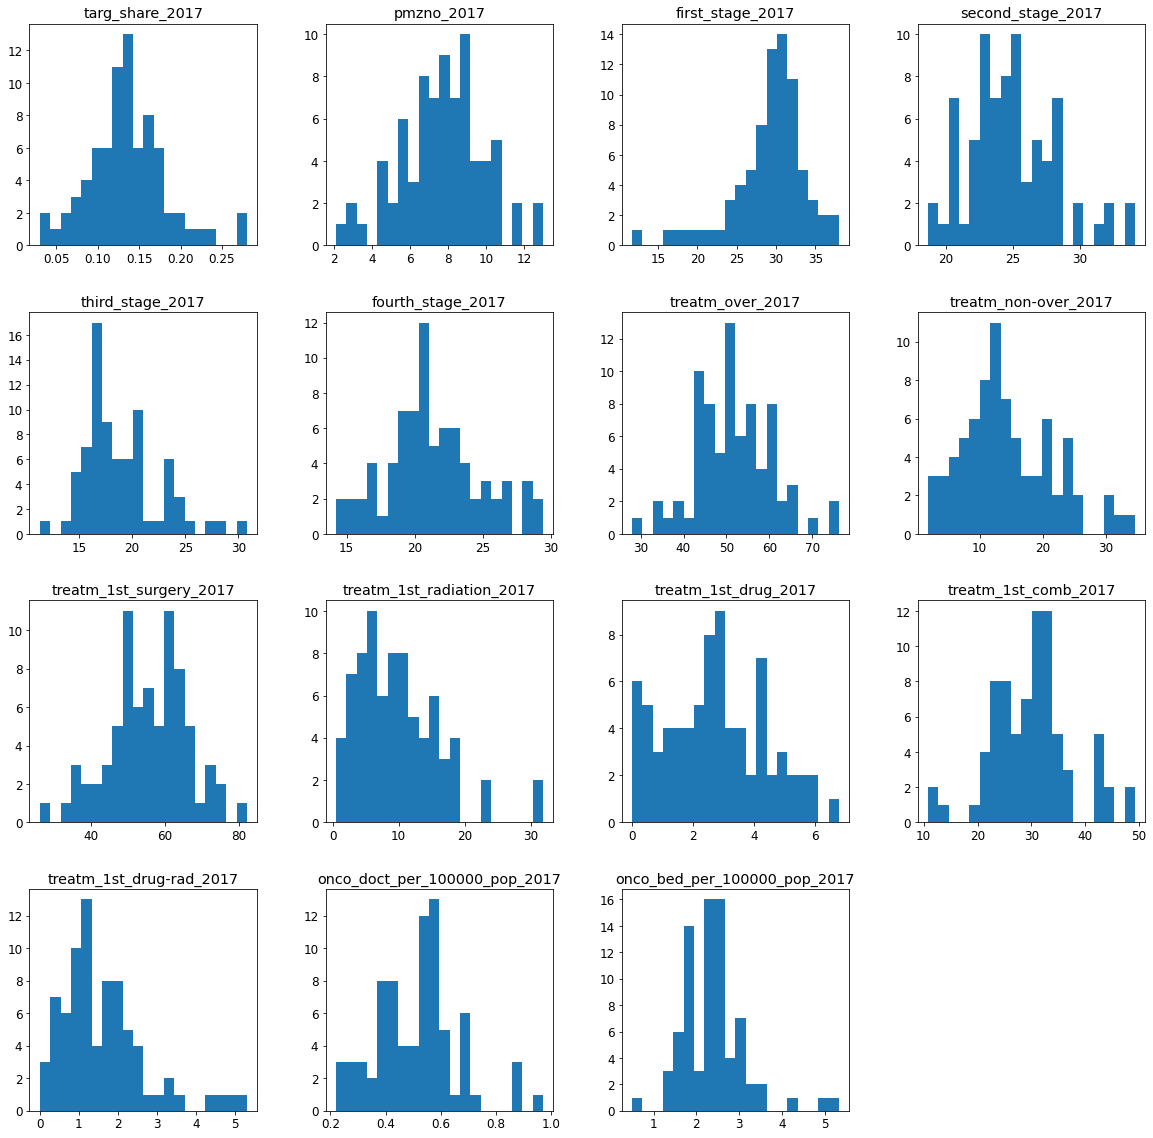

In [16]:
dataset_2017_features_for_1th_year_mort_2017_df.hist(figsize=(20,20), bins=20, grid=False)

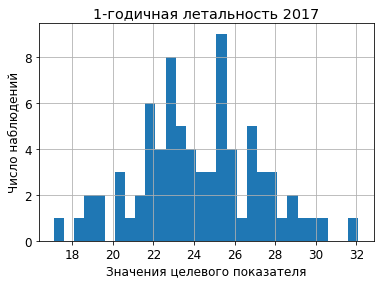

ShapiroResult(statistic=0.9946613907814026, pvalue=0.9881954193115234)
NormaltestResult(statistic=array([0.11843495]), pvalue=array([0.94250178]))
KstestResult(statistic=1.0, pvalue=0.0)


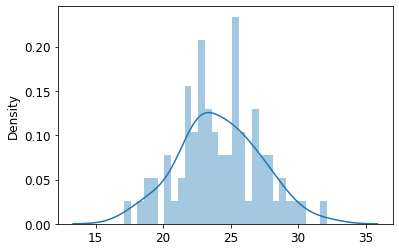

In [13]:
#Проверка нормальности таргета на основном наборе данных

my_hist_norm_distr_test(dataset_2017_1th_year_mort_2017_df[['1th_year_mort_2017']], 30, '1-годичная летальность 2017')

#По результатам тестов Шапиро-Уилка и Normaltest распределение целевого показателя не отличается от нормального распределения

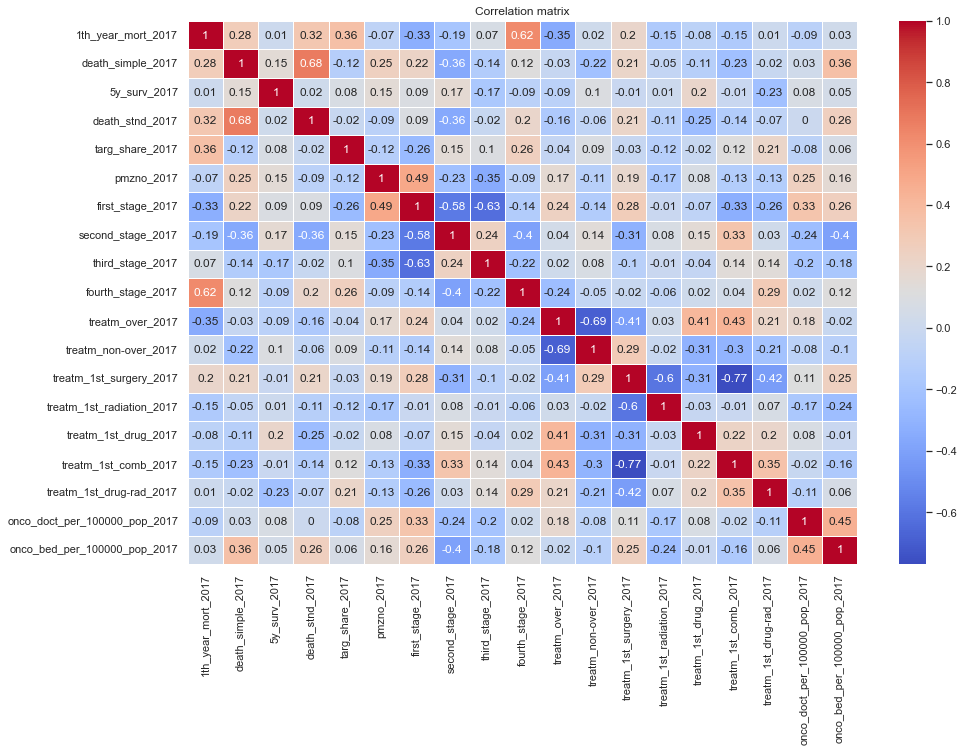

In [17]:
#Корреляционная матрица - выявлялись фичи с высокой коллинеарностью (r=0,7 и выше) из них в анализе оставалась фича с наибольшим r с целевым показателем
my_corr_matrix(dataset_2017_for_1th_year_mort_2017_df_opt, 0.01)

targ_share_2017 0.36492380862945667
pmzno_2017 -0.07015842362975344
first_stage_2017 -0.32682751001144267
second_stage_2017 -0.18963347521989168
third_stage_2017 0.06643611134946938
fourth_stage_2017 0.6212411804242508
treatm_over_2017 -0.34549246516361387
treatm_non-over_2017 0.023414360170002806
treatm_1st_surgery_2017 0.20394678437107486
treatm_1st_radiation_2017 -0.14997888949870009
treatm_1st_drug_2017 -0.0849063016866904
treatm_1st_comb_2017 -0.1454338605860996
treatm_1st_drug-rad_2017 0.012138339283434364
onco_doct_per_100000_pop_2017 -0.09269235991842119
onco_bed_per_100000_pop_2017 0.029191688227471452
                            OLS Regression Results                            
Dep. Variable:     1th_year_mort_2017   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     11.52
Date:                Thu, 08 Dec 2022   Prob (F-statistic):      

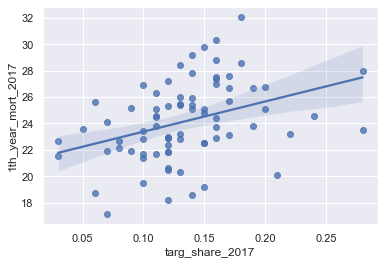

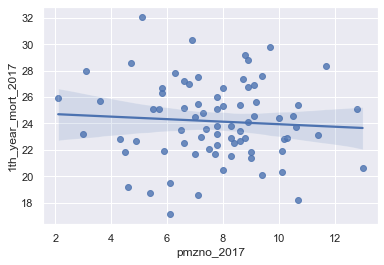

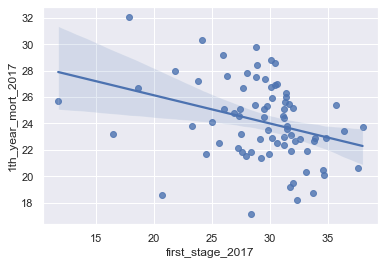

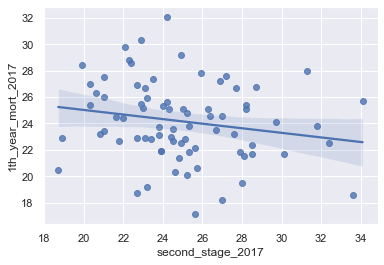

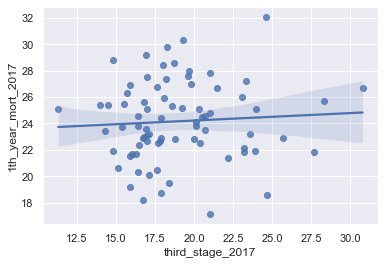

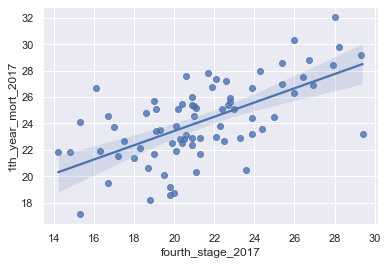

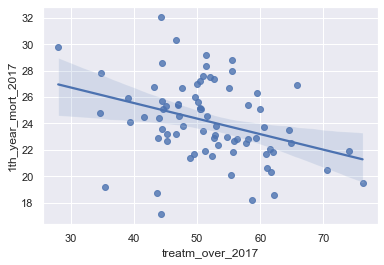

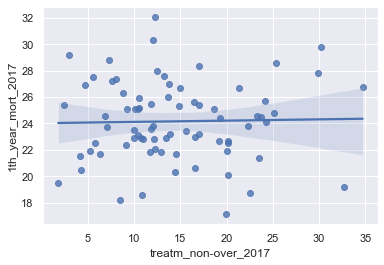

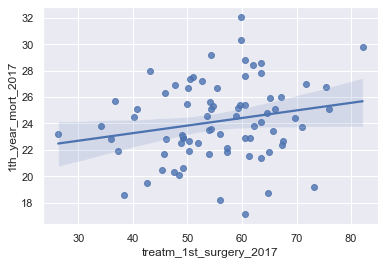

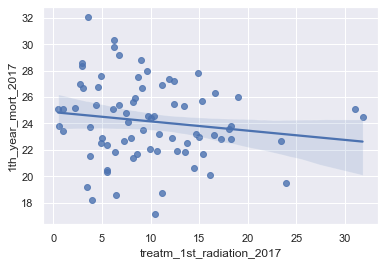

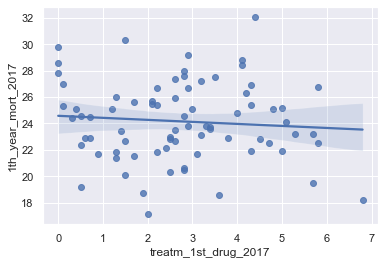

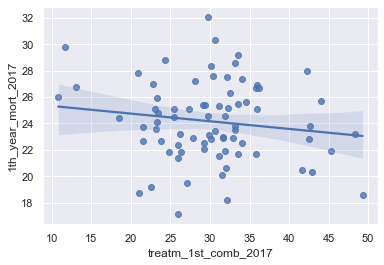

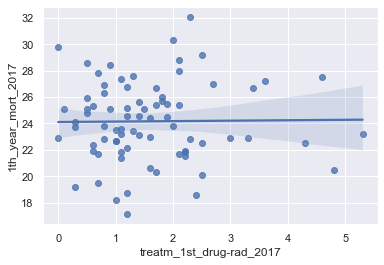

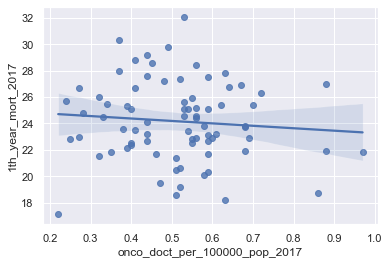

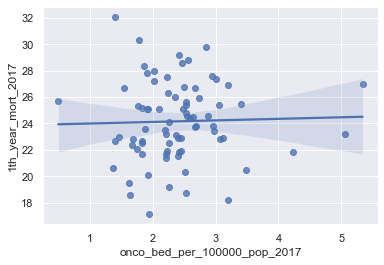

In [19]:
my_project_analysis(dataset_2017_features_for_1th_year_mort_2017_df, dataset_2017_1th_year_mort_2017_df['1th_year_mort_2017'])

In [137]:
dataset_2017_features_for_1th_year_mort_2017_df.columns

Index(['targ_share_2017', 'pmzno_2017', 'first_stage_2017',
       'second_stage_2017', 'third_stage_2017', 'fourth_stage_2017',
       'treatm_over_2017', 'treatm_non-over_2017', 'treatm_1st_surgery_2017',
       'treatm_1st_radiation_2017', 'treatm_1st_drug_2017',
       'treatm_1st_comb_2017', 'treatm_1st_drug-rad_2017',
       'onco_doct_per_100000_pop_2017', 'onco_bed_per_100000_pop_2017'],
      dtype='object')

# Построение итоговых регрессионных моделей

In [ ]:
"""
Построение модели множественной линейной регрессии. 
Модели множественной линейной регрессии строились с использованием двух методов:
- метода включения, что подразумевало последовательное включение переменных с наибольшим R2, рассчитанным на предыдущем этапе, 
до тех пор, пока наблюдался прирост R2 общей модели. Потенциальные предикторы с р≥0,05 в общей модели исключались из неё;
- метода исключения, что означало исходное включение в модель всех потенциальных предикторов с последующим поочередным
исключением предикторов с наибольшим показателем р≥0,05. Модель считалась завершенной, когда в неё входили лишь 
предикторы, оказывающие статистически значимое влияние на целевой показатель. 

Качество моделей оценивалось по:
- величине R2 – чем значение ближе к 1, тем лучше модель объясняет целевую переменную;
- результату теста Харке-Бера [22], который позволяет оценить нормальность остатков, при р≥0,05 считается, что остатки 
распределены нормально, если р≤0,05, то считается, что распределение остатков отличается от нормального, соответственно это 
приводит к снижению точности модели, поэтому модели с распределением остатков отличающимся от нормального (р≤0,05 теста 
Харке-Бера) исключались и не описывались в разделе с результатами. 
- наличию мультиколлинеарности, что означает, что в модель включены коррелирующие предикторы, что снижает точность модели 
(повышение стандартной ошибки коэффициентов и занижение значимости влияния предикторов). При наличии риска 
мультиколлинеарности при описании модели данный факт фиксировался. Исключались и в дальнейшем не описывались модели с 
риском мультиколлинеарности, содержащие предикторы с величиной связи 0,7 и более. 
"""

In [21]:
#Итоговая отобранная модель №1

my_regression_simple(dataset_2017_features_for_1th_year_mort_2017_df[['targ_share_2017', 'fourth_stage_2017']], dataset_2017_1th_year_mort_2017_df)

                            OLS Regression Results                            
Dep. Variable:     1th_year_mort_2017   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     28.08
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           8.42e-10
Time:                        17:17:35   Log-Likelihood:                -171.39
No. Observations:                  77   AIC:                             348.8
Df Residuals:                      74   BIC:                             355.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.8263      1.68

In [22]:
#Итоговая отобранная модель №2

my_regression_simple(dataset_2017_features_for_1th_year_mort_2017_df[['fourth_stage_2017', 'treatm_over_2017']], dataset_2017_1th_year_mort_2017_df)

                            OLS Regression Results                            
Dep. Variable:     1th_year_mort_2017   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     27.66
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.07e-09
Time:                        17:18:09   Log-Likelihood:                -171.64
No. Observations:                  77   AIC:                             349.3
Df Residuals:                      74   BIC:                             356.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                17.2830      2.59

In [ ]:
#В результате для одногодичной летальности были отобраны 2 модели с R2=0,431 R2=0,428
#По причине низкой величины R2 обе модели были признаны недостаточно точными для применения на практике

In [ ]:
"""
В качестве основной технической причины низкой точности моделей бы выделена слабая линейная связь между фичами и целевыми 
переменными. Исходные неточности в статистике потенциально также могли оказать влияние, но проверить их влияние не 
представлялось возможным.

Также был проведена кросвалидация, когда в модели 2017 года подставлялись даныне других годов - качество сильно снижалось, 
из чего был сделан вывод, что полученные результаты случайны и не являются закономерностью.

В перспективе есть планы построить модели с использованием других моделей (случайный лес, прочие ансамблевые методы).
"""